In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import copy
import os
import time

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import shap
shap.initjs()

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                            )

from fairlearn.metrics import (MetricFrame,
                               false_positive_rate,
                               selection_rate,
                               true_positive_rate,
                               count,
                              )

# Read in data

In [4]:
df_categories = pd.read_csv('2018_ACSIncome_MA_categories.csv')
df_categories

,AGEP,SCHL,MAR,OCCP,WKHP,SEX,PINCP
0,18.0,SCHL18,Never_Married,EDU,7.0,Female,3000.0
1,28.0,SCHL21,Never_Married,CLN,60.0,Male,35000.0
2,22.0,SCHL19,Never_Married,EDU,25.0,Male,4000.0
3,18.0,SCHL18,Never_Married,SAL,50.0,Male,12000.0
4,20.0,SCHL19,Never_Married,RPR,40.0,Male,5000.0
...,...,...,...,...,...,...,...
40109,21.0,SCHL19,Never_Married,HLS,15.0,Female,15600.0
40110,47.0,SCHL21,Married,CMM,40.0,Female,72000.0
40111,46.0,SCHL21,Married,MGR,50.0,Male,150000.0
40112,36.0,SCHL22,Married,MGR,40.0,Female,78000.0


In [5]:
df = pd.read_csv('2018_ACSIncome_MA_int_categories.csv')
df

,AGEP,SCHL,MAR,OCCP,WKHP,SEX,PINCP
0,18.0,3,5,6,7.0,1,3000.0
1,28.0,6,5,1,60.0,0,35000.0
2,22.0,4,5,6,25.0,0,4000.0
3,18.0,3,5,22,50.0,0,12000.0
4,20.0,4,5,21,40.0,0,5000.0
...,...,...,...,...,...,...,...
40109,21.0,4,5,12,15.0,1,15600.0
40110,47.0,6,0,2,40.0,1,72000.0
40111,46.0,6,0,15,50.0,0,150000.0
40112,36.0,7,0,15,40.0,1,78000.0


In [6]:
# apply an arbitrary cutoff to frame this as binary classification
df['target'] = df.PINCP.apply(lambda x: x>35000)
df

,AGEP,SCHL,MAR,OCCP,WKHP,SEX,PINCP,target
0,18.0,3,5,6,7.0,1,3000.0,False
1,28.0,6,5,1,60.0,0,35000.0,False
2,22.0,4,5,6,25.0,0,4000.0,False
3,18.0,3,5,22,50.0,0,12000.0,False
4,20.0,4,5,21,40.0,0,5000.0,False
...,...,...,...,...,...,...,...,...
40109,21.0,4,5,12,15.0,1,15600.0,False
40110,47.0,6,0,2,40.0,1,72000.0,True
40111,46.0,6,0,15,50.0,0,150000.0,True
40112,36.0,7,0,15,40.0,1,78000.0,True


# Do not use sex here

In [7]:
feat_names = df.columns[:5].values.tolist()
print(feat_names)
X = df[feat_names]
X

['AGEP', 'SCHL', 'MAR', 'OCCP', 'WKHP']


,AGEP,SCHL,MAR,OCCP,WKHP
0,18.0,3,5,6,7.0
1,28.0,6,5,1,60.0
2,22.0,4,5,6,25.0
3,18.0,3,5,22,50.0
4,20.0,4,5,21,40.0
...,...,...,...,...,...
40109,21.0,4,5,12,15.0
40110,47.0,6,0,2,40.0
40111,46.0,6,0,15,50.0
40112,36.0,7,0,15,40.0


In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40114 entries, 0 to 40113
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    40114 non-null  float64
 1   SCHL    40114 non-null  int64  
 2   MAR     40114 non-null  int64  
 3   OCCP    40114 non-null  int64  
 4   WKHP    40114 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 1.5 MB


In [9]:
# use the correct type for the categorical features
col_cat = ['SCHL', 'MAR', 'OCCP']
for col in col_cat:
    X.loc[:, col] = X[col].astype('category')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40114 entries, 0 to 40113
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   AGEP    40114 non-null  float64 
 1   SCHL    40114 non-null  category
 2   MAR     40114 non-null  category
 3   OCCP    40114 non-null  category
 4   WKHP    40114 non-null  float64 
dtypes: category(3), float64(2)
memory usage: 745.7 KB



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
X_display = df_categories[feat_names]

,AGEP,SCHL,MAR,OCCP,WKHP
0,18.0,SCHL18,Never_Married,EDU,7.0
1,28.0,SCHL21,Never_Married,CLN,60.0
2,22.0,SCHL19,Never_Married,EDU,25.0
3,18.0,SCHL18,Never_Married,SAL,50.0
4,20.0,SCHL19,Never_Married,RPR,40.0
...,...,...,...,...,...
40109,21.0,SCHL19,Never_Married,HLS,15.0
40110,47.0,SCHL21,Married,CMM,40.0
40111,46.0,SCHL21,Married,MGR,50.0
40112,36.0,SCHL22,Married,MGR,40.0


In [11]:
# this is reasonably balanced
# to make it more balanced, different thresholds could be used 
# alternatively, we could either upsample or downsample the corresponding class if desired
y = df.target.values
print(f'{y.sum() / len(y) *100:.1f}% of samples belong to the positive class')

61.4% of samples belong to the positive class


In [12]:
# create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

# no need to provide categorical_feature since we set the type to categorical above
d_train = lgb.Dataset(X_train, label=y_train) #, categorical_feature=col_cat)  
d_val = lgb.Dataset(X_val, label=y_val) # , categorical_feature=col_cat)
d_test = lgb.Dataset(X_test, label=y_test) # , categorical_feature=col_cat)

In [13]:
# create train and test data for shap display
X_train_display, X_test_display, y_train, y_test = train_test_split(X_display, y, test_size=0.7, random_state=42, stratify=y)
X_val_display, X_test_display, y_val, y_test = train_test_split(X_test_display, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Train model

In [14]:
# hyperparameter tuning could be performed if desired
params = {
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.train(params,
                  train_set=d_train, 
                  num_boost_round=1000,
                  valid_sets=[d_val],
                  early_stopping_rounds=50,
                  verbose_eval=100,
                 )

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.38052


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[200]	valid_0's binary_logloss: 0.37812
Early stopping, best iteration is:
[239]	valid_0's binary_logloss: 0.377831


In [15]:
# check that categorical columns are correct. yep!
model.params

{'learning_rate': 0.05,
 'boosting_type': 'gbdt',
 'objective': 'binary',
 'metric': 'binary_logloss',
 'num_leaves': 10,
 'verbose': -1,
 'min_data': 100,
 'boost_from_average': True,
 'num_iterations': 1000,
 'early_stopping_round': 50,
 'categorical_column': [1, 2, 3]}

In [16]:
def determine_cutoff(model, X_train, y_train, X_val, y_val, num_cutoffs=20):
    cutoffs = np.arange(0, 1, 1/num_cutoffs)
    val_scores = np.zeros(num_cutoffs)
    for i, cutoff in enumerate(cutoffs):
        # validation error
        y_val_pred = model.predict(X_val)
        y_val_pred = np.array([1 if x >= cutoff else 0 for x in y_val_pred])
        acc = accuracy_score(y_val, y_val_pred)
        val_scores[i] = acc
        
    best_idx = np.argmax(val_scores)
    print(f'Best Validation Accuracy is {val_scores[best_idx]:.3f} with cutoff: {cutoffs[best_idx]}')
    
    return cutoffs[best_idx]

In [17]:
best_cutoff = determine_cutoff(model, X_train, y_train, X_val, y_val, num_cutoffs=20)

Best Validation Accuracy is 0.831 with cutoff: 0.5


In [18]:
# training error
y_train_pred = model.predict(X_train)
y_train_pred = np.array([1 if x >= best_cutoff else 0 for x in y_train_pred])
acc = accuracy_score(y_train, y_train_pred)
print(f'Training Accuracy:   {acc:.3f}')

# validation error
y_val_pred = model.predict(X_val)
y_val_pred = np.array([1 if x >= best_cutoff else 0 for x in y_val_pred])
acc = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {acc:.3f}')

# testing error
y_test_pred = model.predict(X_test)
y_test_pred = np.array([1 if x >= best_cutoff else 0 for x in y_test_pred])
acc = accuracy_score(y_test, y_test_pred)
print(f'Testing Accuracy:    {acc:.3f}')

Training Accuracy:   0.849
Validation Accuracy: 0.831
Testing Accuracy:    0.825


## Explain predictions

Here we use the Tree SHAP implementation integrated into Light GBM to explain the test dataset

In [19]:
explainer = shap.TreeExplainer(model)

## Visualize a single prediction

In [20]:
# shapely values with Tree SHAP
# get predictions for predicting 1 i.e. above the threshold
i = 119
shap_values_single = explainer.shap_values(X_test.iloc[[i]])
shap.force_plot(explainer.expected_value[1], shap_values_single[1], X_test_display.iloc[[i]])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [21]:
# shapely values with Tree SHAP
# get predictions for predicting 1 i.e. above the threshold
i = 20
shap_values_single = explainer.shap_values(X_test.iloc[[i]])
shap.force_plot(explainer.expected_value[1], shap_values_single[1], X_test_display.iloc[[i]])

## SHAP Summary Plot

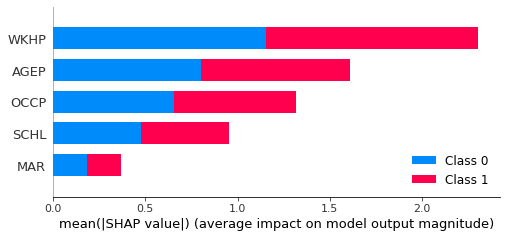

In [22]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

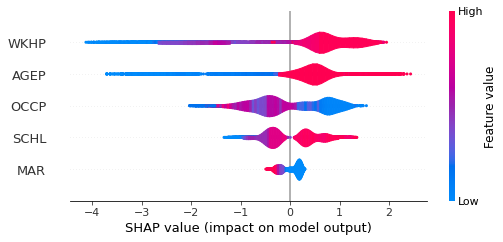

In [23]:
# shap values for predicting class 1 i.e. above the income threshold
shap.summary_plot(shap_values[1], X_test, plot_type="violin")

### Visualize many predictions

To keep the browser happy we only visualize 100 individuals.

In [24]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:100,:], X_test_display.iloc[:100,:])

## SHAP Dependence Plots


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


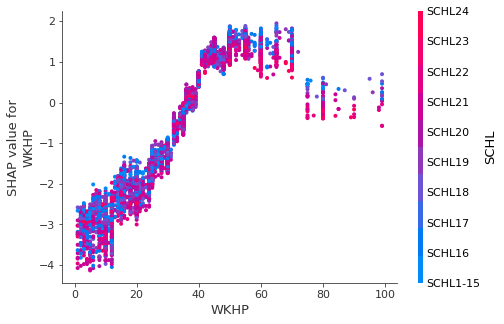

In [25]:
feat_name = 'WKHP'
shap.dependence_plot(feat_name, shap_values[1], X_test, display_features=X_test_display)

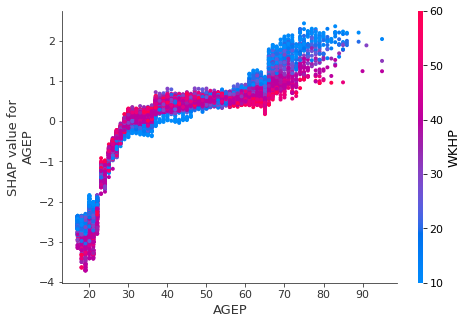

In [26]:
feat_name = 'AGEP'
shap.dependence_plot(feat_name, shap_values[1], X_test, display_features=X_test_display)

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


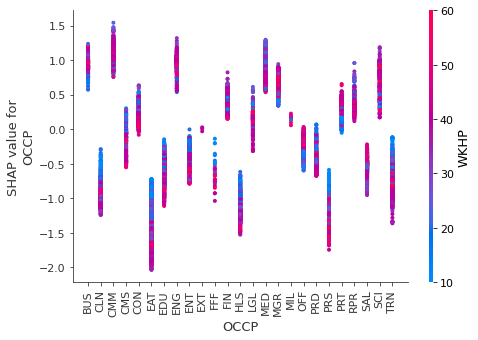

In [27]:
# as expected, occupations like ENG (engineer), MED (medicne), MGR (manager), LGL (legal), etc contribute positively to income
feat_name = 'OCCP'
shap.dependence_plot(feat_name, shap_values[1], X_test, display_features=X_test_display)

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


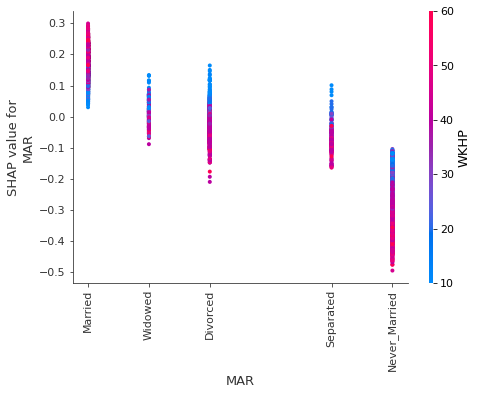

In [28]:
feat_name = 'MAR'
shap.dependence_plot(feat_name, shap_values[1], X_test, display_features=X_test_display)

# Look at fairness by sex on the testing set

In [29]:
df_categories = pd.read_csv('2018_ACSIncome_MA_categories.csv')
X_display = df_categories[['SEX']]
X_display

,SEX
0,Female
1,Male
2,Male
3,Male
4,Male
...,...
40109,Female
40110,Female
40111,Male
40112,Female


In [30]:
# create train and test data
X_train_display, X_test_display, y_train, y_test = train_test_split(X_display, y, test_size=0.7, random_state=42, stratify=y)
X_val_display, X_test_display, y_val, y_test = train_test_split(X_test_display, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [31]:
sex = X_test_display.SEX
gm = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_test_pred, sensitive_features=sex)
print(f'Overall Accuracy: {gm.overall:.3f}')
print(gm.by_group)
print(f'Difference: {gm.difference():.3f}')

Overall Accuracy: 0.825
SEX
Female      0.8178
Male      0.831978
Name: accuracy_score, dtype: object
Difference: 0.014


In [32]:
gm = MetricFrame(metrics=precision_score, y_true=y_test, y_pred=y_test_pred, sensitive_features=sex)
print(f'Overall Precision: {gm.overall:.3f}')
print(gm.by_group)
print(f'Difference: {gm.difference():.3f}')

Overall Precision: 0.836
SEX
Female    0.808315
Male      0.858534
Name: precision_score, dtype: object
Difference: 0.050


In [33]:
gm = MetricFrame(metrics=recall_score, y_true=y_test, y_pred=y_test_pred, sensitive_features=sex)
print(f'Overall Recall: {gm.overall:.3f}')
print(gm.by_group)
print(f'Difference: {gm.difference():.3f}')

Overall Recall: 0.890
SEX
Female     0.87769
Male      0.898897
Name: recall_score, dtype: object
Difference: 0.021


In [34]:
gm = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_test_pred, sensitive_features=sex)
print(f'Overall Selection Rate: {gm.overall:.3f}')
print(gm.by_group)
print(f'Difference: {gm.difference():.3f}')

Overall Selection Rate: 0.653
SEX
Female    0.598698
Male      0.705891
Name: selection_rate, dtype: object
Difference: 0.107


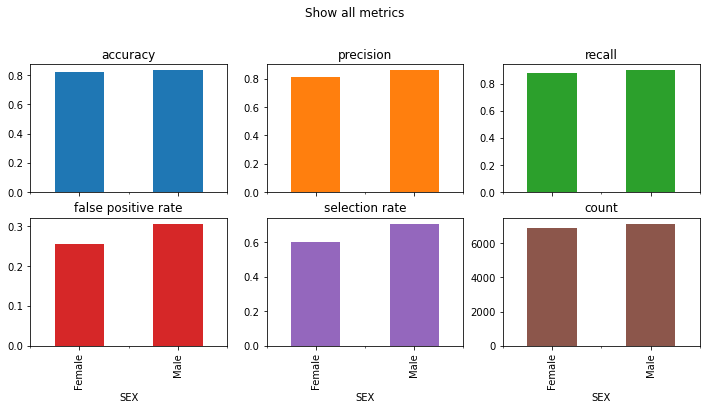

In [35]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "false positive rate": false_positive_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_test_pred, sensitive_features=sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
);